# **AdaBoost Classifier From Scratch in Python**
*By Cristian Leo*

*Article Link*: https://medium.com/stackademic/building-adaboost-from-scratch-in-python-18b79061fe01
## **Import Libraries**

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd

# Load Data
from sklearn.datasets import load_breast_cancer

# Split Data
from sklearn.model_selection import train_test_split

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## **Build AdaBoost From Scratch**
### **Decision Stump Function**

In [2]:
# A simple implementation of a weak classifier - decision stump
def decision_stump(X, y, weights):
    # Get the number of features in the dataset
    num_features = X.shape[1]
    
    # Initialize the best stump and the minimum error
    best_stump = {}
    min_error = float('inf')
    
    # Loop over each feature in the dataset
    for feature in range(num_features):
        # Get the unique values of the current feature
        feature_values = np.unique(X[:, feature])
        
        # Loop over each unique value as a potential threshold
        for threshold in feature_values:
            # Loop over the two possible inequalities
            for inequality in ["lt", "gt"]:
                # Initialize the predictions to 0
                predictions = np.zeros(len(y))
                
                # If the inequality is "lt", set the predictions to 1 where the feature values are less than or equal to the threshold
                if inequality == "lt":
                    predictions[X[:, feature] <= threshold] = 1
                # If the inequality is "gt", set the predictions to 1 where the feature values are greater than the threshold
                else:
                    predictions[X[:, feature] > threshold] = 1

                # Calculate the misclassified examples
                misclassified = predictions != y
                # Calculate the weighted error by taking the dot product of the weights and the misclassified examples
                weighted_error = np.dot(weights, misclassified)

                # If the weighted error is less than the current minimum error, update the best stump and the minimum error
                if weighted_error < min_error:
                    min_error = weighted_error
                    best_stump['feature'] = feature
                    best_stump['threshold'] = threshold
                    best_stump['inequality'] = inequality
                    best_stump['predictions'] = predictions

    # Return the best stump and the minimum error
    return best_stump, min_error

### **Main AdaBoost Model**

In [3]:
# AdaBoost implementation
class AdaBoost:
    """
    This class implements the AdaBoost algorithm, a boosting algorithm that combines multiple weak classifiers 
    to create a strong classifier. The weak classifiers are trained in a sequential manner, where each classifier 
    is trained to correct the mistakes of the previous classifiers. The final prediction is a weighted vote of 
    the predictions of the weak classifiers.

    Attributes:
        T (int): The number of weak classifiers.
        weak_classifiers (list): A list to store the weak classifiers.

    Methods:
        fit(X, y): Trains the AdaBoost model on the given data.
        predict(X): Makes predictions on the given data using the trained model.
    """
    def __init__(self, T=50):
        self.T = T  # Number of weak classifiers
        self.weak_classifiers = []  # List to store the weak classifiers

    def fit(self, X, y):
        # Initialize weights uniformly
        weights = np.full(len(y), (1 / len(y)))

        # Train T weak classifiers
        for _ in range(self.T):
            # Get the best decision stump and its error for the current weights
            stump, error = decision_stump(X, y, weights)

            # Handle zero error case to avoid division by zero
            if error == 0:
                error = 1e-10

            # Compute alpha (amount of say)
            alpha = 0.5 * np.log((1 - error) / error)
            # Store alpha in the stump
            stump['alpha'] = alpha
            # Add the stump to the list of weak classifiers
            self.weak_classifiers.append(stump)

            # Update the weights
            predictions = stump['predictions']
            # Adjust y from {0, 1} to {-1, 1} for weight update
            adjusted_y = np.where(y == 0, -1, 1)
            # Update weights based on the predictions
            weights *= np.exp(-alpha * adjusted_y * (2 * predictions - 1))  # predictions are {0, 1}, converting to {-1, 1}
            # Normalize the weights
            weights /= np.sum(weights)

    def predict(self, X):
        # Initialize final predictions
        final_predictions = np.zeros(len(X))

        # For each weak classifier
        for stump in self.weak_classifiers:
            # Initialize predictions to 0
            predictions = np.zeros(len(X))  # default to 0
            # Get the feature, threshold, and inequality from the stump
            feature = stump['feature']
            threshold = stump['threshold']
            inequality = stump['inequality']

            # Make predictions based on the feature, threshold, and inequality
            if inequality == "lt":
                predictions[X[:, feature] <= threshold] = 1
            else:
                predictions[X[:, feature] > threshold] = 1

            # Add the weighted predictions to the final predictions
            final_predictions += stump['alpha'] * (2 * predictions - 1)  # converting {0, 1} to {-1, 1}

        # Return the final predictions, converting {-1, 1} back to {0, 1}
        return np.where(final_predictions >= 0, 1, 0)  # return {0, 1} based on sign of final_predictions

### **Finetuning and Visualization Class**

In [4]:
class AdaBoostTester:
    """
    This class is designed to test the performance of the AdaBoost algorithm with different numbers of weak learners.
    It provides methods to train the model, test its accuracy, and plot the accuracy against the number of weak learners.

    Attributes:
        X_train (numpy.ndarray): The training data.
        y_train (numpy.ndarray): The labels for the training data.
        X_test (numpy.ndarray): The testing data.
        y_test (numpy.ndarray): The labels for the testing data.
        accuracies (list): A list to store the accuracy of the model for each number of weak learners.
        best_accuracy (float): The best accuracy achieved by the model.
        best_model (AdaBoost): The model that achieved the best accuracy.

    Methods:
        test(T_values): Trains an AdaBoost model for each value in T_values, tests the model's accuracy on the test set, 
                        and keeps track of the model with the best accuracy.
        plot(T_values): Plots the accuracies against the number of weak learners.
        get_best_model(): Returns the model that achieved the best accuracy.
        get_best_accuracy(): Returns the best accuracy achieved by the model.
    """
    def __init__(self, X_train, y_train, X_test, y_test):
        # Initialize the training and testing data, the list of accuracies, and the best model and accuracy
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.accuracies = []
        self.best_accuracy = 0
        self.best_model = None

    def test(self, T_values):
        # For each value in T_values, train an AdaBoost model and test its accuracy
        for i, T_value in enumerate(T_values):
            # Initialize and train the AdaBoost model
            adaBoostModel = AdaBoost(T=T_value)
            adaBoostModel.fit(self.X_train, self.y_train)
            
            # Make predictions on the test set and calculate the accuracy
            predictions = adaBoostModel.predict(self.X_test)
            accuracy = (predictions == self.y_test).mean()
            
            # Add the accuracy to the list of accuracies
            self.accuracies.append(accuracy)
            
            # Print the progress
            print(f"T = {T_value}, Test Accuracy = {accuracy:.2%} | {(i+1)/len(T_values):.2%} complete")
            
            # If this model has the best accuracy so far, update the best model and accuracy
            if accuracy > self.best_accuracy:
                self.best_accuracy = accuracy
                self.best_model = adaBoostModel

    def plot(self, T_values):
        # Plot the accuracies against the T_values
        plt.figure(figsize=(10, 6))
        plt.plot(T_values, self.accuracies, marker='o')
        plt.title('Accuracy vs Number of Weak Learners')
        plt.xlabel('Number of Weak Learners (T)')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.show()
    
    def get_best_model(self):
        # Return the best model
        return self.best_model
    
    def get_best_accuracy(self):
        # Return the best accuracy
        return self.best_accuracy

## **Load Breast Cancer Dataset**

In [5]:
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# Create a DataFrame
df = pd.DataFrame(X, columns=cancer.feature_names)
df['target'] = y

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## **EDA**

<Figure size 2000x1000 with 0 Axes>

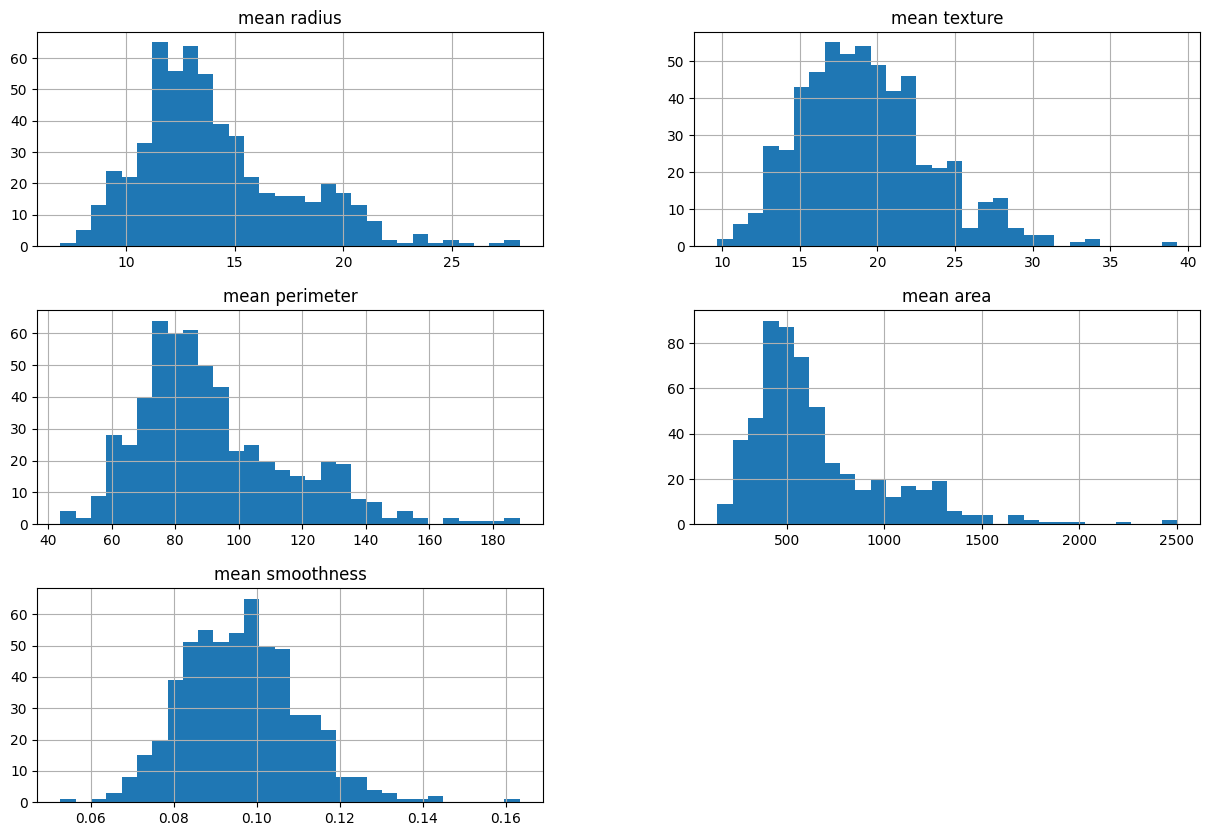

In [6]:
# Plot the distribution of the features
plt.figure(figsize=(20, 10))
df.iloc[:, :5].hist(bins=30, figsize=(15, 10))
plt.show()

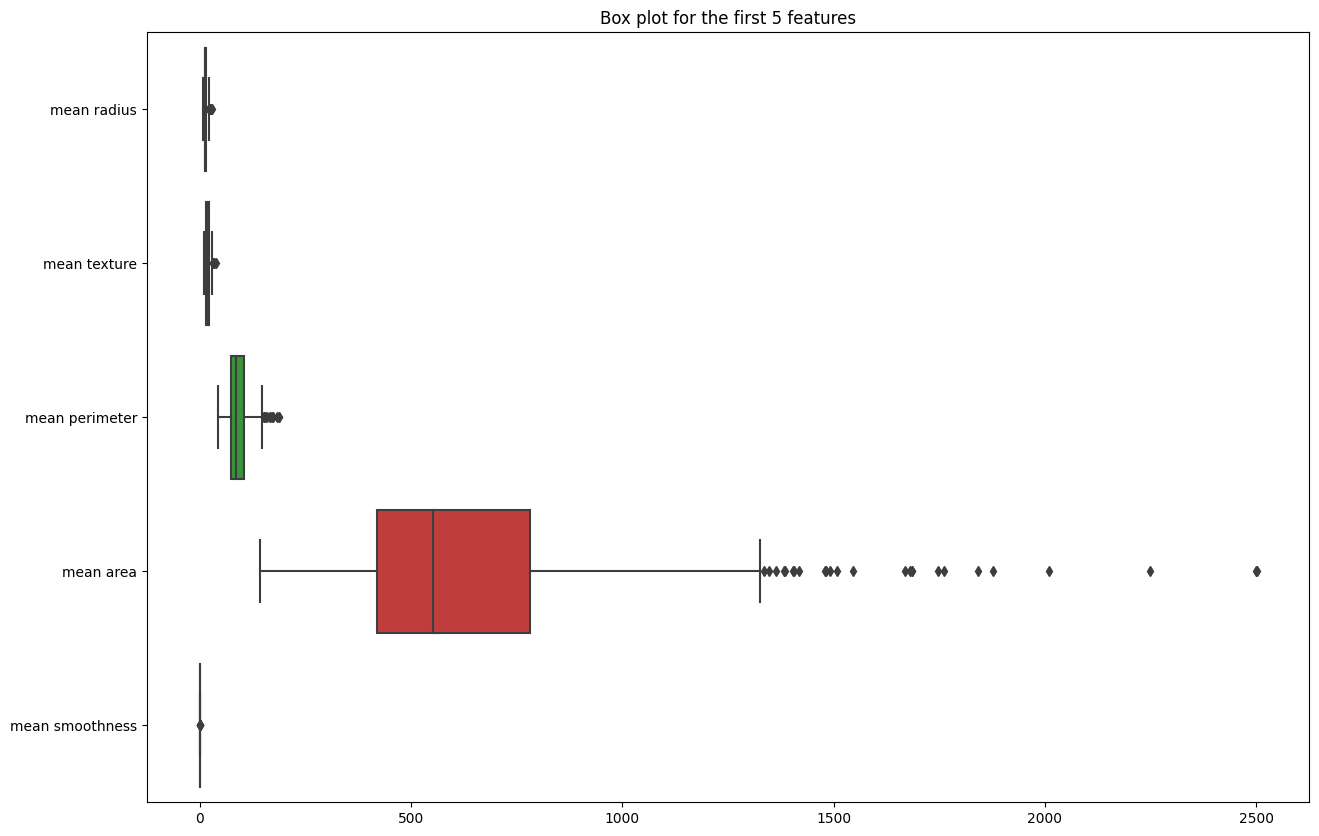

In [7]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df.iloc[:, :5], orient="h")
plt.title('Box plot for the first 5 features')
plt.show()

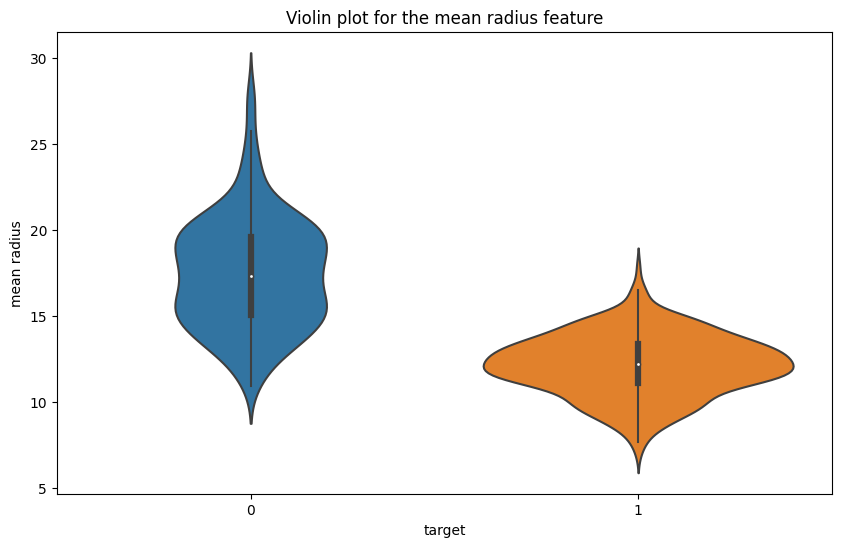

In [8]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='target', y='mean radius', data=df)
plt.title('Violin plot for the mean radius feature')
plt.show()

## **Predict Data**

T = 10, Test Accuracy = 95.32% | 10.00% complete
T = 20, Test Accuracy = 96.49% | 20.00% complete
T = 30, Test Accuracy = 95.91% | 30.00% complete
T = 40, Test Accuracy = 96.49% | 40.00% complete
T = 50, Test Accuracy = 97.08% | 50.00% complete
T = 60, Test Accuracy = 97.08% | 60.00% complete
T = 70, Test Accuracy = 96.49% | 70.00% complete
T = 80, Test Accuracy = 95.91% | 80.00% complete
T = 90, Test Accuracy = 97.08% | 90.00% complete
T = 100, Test Accuracy = 95.91% | 100.00% complete
Best Accuracy = 97.08%


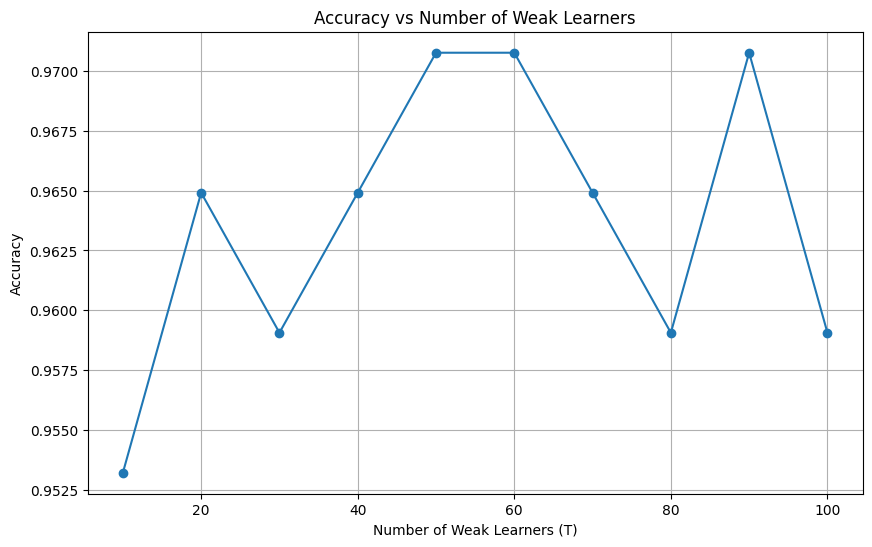

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

T_values = list(range(10, 101, 10))
tester = AdaBoostTester(X_train, y_train, X_test, y_test)
tester.test(T_values)
print(f"Best Accuracy = {tester.get_best_accuracy():.2%}")
tester.plot(T_values)